In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Reading in the the dunking data.

# Initial exploratory analysis of the data

In [2]:
dunking_data = pd.read_csv('dunking-data.csv')


fig, ax = plt.subplots(figsize=(10, 6))


biscuit_types = dunking_data['biscuit'].unique()
colors = ['blue', 'green', 'red']  
markers = ['o', '^', 's']  


for biscuit, color, marker in zip(biscuit_types, colors, markers):
    subset = dunking_data[dunking_data['biscuit'] == biscuit]
    ax.scatter(subset['t'], subset['L'], color=color, marker=marker, s=100, label=biscuit)

ax.set_xlabel('Time after Dunking (s)')
ax.set_ylabel('Length Tea Soaked by Biscuit (m)')
ax.set_title('Tea Absorption in Biscuits Over Time')

ax.legend(title='Biscuit Type')

ax.grid(True)
plt.show()



Can't see much with time vs length
- Digestives seem to have a high variability in length although this could be due to the angle
- Rich teas seem to have the lowest absorption
- Hobnobs down the middle

In [4]:



fig, ax = plt.subplots(figsize=(10, 6))


biscuit_types = dunking_data['biscuit'].unique()
colors = ['blue', 'green', 'red']  
markers = ['o', '^', 's']  


for biscuit, color, marker in zip(biscuit_types, colors, markers):
    subset = dunking_data[dunking_data['biscuit'] == biscuit]
    ax.scatter(subset['phi'], subset['L'], color=color, marker=marker, s=100, label=biscuit)

ax.set_xlabel('Angle of Dunkage (rad)')
ax.set_ylabel('Length Tea Soaked by Biscuit (m)')
ax.set_title('Tea Absorption in Biscuits Over Time')

ax.legend(title='Biscuit Type')

ax.grid(True)
plt.show()

All biscuit types are impacted by the angle of dunkage. Can see more clearly that digestives are, on the whole, more absorbent than hobnobs which are generally more absorbent than rich teas.

In [7]:
# Getting basic summary statistics of length grouped by biscuit type
summary_stats = dunking_data.groupby('biscuit')[["L"]].describe()

summary_stats


L                                                              \
            count      mean       std       min       25%       50%       75%   
biscuit                                                                         
Digestive  1000.0  0.007864  0.003604  0.000329  0.005221  0.007630  0.010143   
Hobnob     1000.0  0.006022  0.002861  0.000185  0.003891  0.005763  0.007842   
Rich Tea   1000.0  0.004843  0.002150  0.000392  0.003306  0.004721  0.006188   

                     
                max  
biscuit              
Digestive  0.019230  
Hobnob     0.015657  
Rich Tea   0.011808

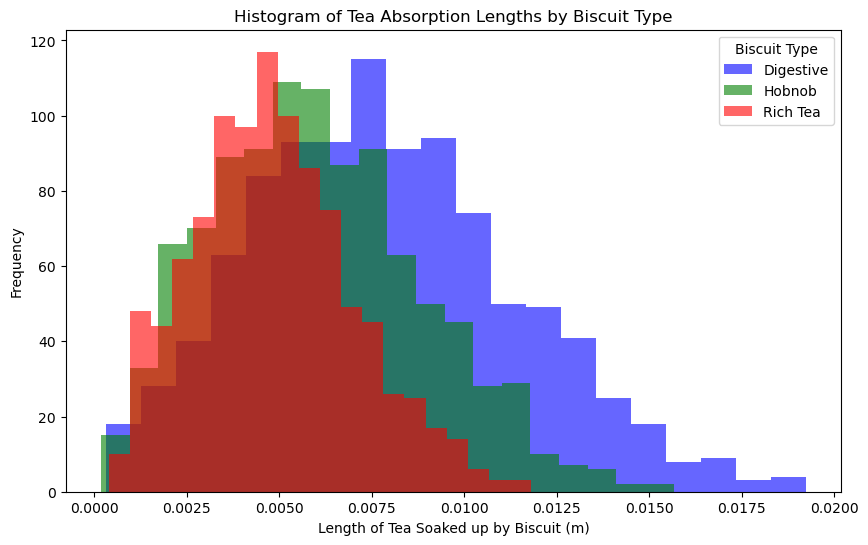

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

biscuit_types = dunking_data['biscuit'].unique()

colors = ['blue', 'green', 'red']  # Adjust colors as needed

# Plotting histograms for each biccy type
for biscuit, color in zip(biscuit_types, colors):
    subset = dunking_data[dunking_data['biscuit'] == biscuit]
    ax.hist(subset['L'], bins=20, alpha=0.6, label=biscuit, color=color)

ax.set_xlabel('Length of Tea Soaked up by Biscuit (m)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Tea Absorption Lengths by Biscuit Type')
ax.legend(title='Biscuit Type')

# Show the plot
plt.show()

All data is normally distributed. Again can see tea travels further in digestives than hobnobs and hobnobs generally has tea travel further than rich teas.

Checking the shape of the dunking data

In [10]:

dunking_data.shape

(3000, 6)

Looking at the headings and top few rows of the dunking data to see what is there.

In [11]:
dunking_data.head()

gamma       phi       eta         L          t    biscuit
0  0.073897  1.333006  0.000999  0.011196  19.362214  Digestive
1  0.080946  1.476758  0.001012  0.005894  11.852589  Digestive
2  0.087408  1.477141  0.000984  0.009249  24.793669  Digestive
3  0.070793  1.502001  0.001002  0.003774  16.292780     Hobnob
4  0.058917  1.548274  0.001004  0.002291  13.662271     Hobnob

Checking for any null values

In [12]:
dunking_data.isnull().sum()

gamma      0
phi        0
eta        0
L          0
t          0
biscuit    0
dtype: int64

Removing the biscuit category so that the random forest model can be trained.

In [13]:
X = dunking_data[dunking_data.columns[:-1]]
X.head()

gamma       phi       eta         L          t
0  0.073897  1.333006  0.000999  0.011196  19.362214
1  0.080946  1.476758  0.001012  0.005894  11.852589
2  0.087408  1.477141  0.000984  0.009249  24.793669
3  0.070793  1.502001  0.001002  0.003774  16.292780
4  0.058917  1.548274  0.001004  0.002291  13.662271

Scaling the data (X) so that each feature has a mean of 0 and variance of 1.

In [14]:
scaled_X = StandardScaler().fit_transform(X)
scaled_X

array([[ 0.06596114, -1.16247713, -0.1763231 ,  1.55578257, -0.08375485],
       [ 0.77413155,  0.35248485,  1.10014727, -0.10948028, -1.37661828],
       [ 1.42325581,  0.356527  , -1.66054277,  0.94409822,  0.85132923],
       ...,
       [-1.37764073,  0.01241775, -0.27264257,  0.42085499,  1.13891337],
       [-0.18625557, -2.43547144,  0.29222623,  2.43276913,  0.50332741],
       [ 0.95267679,  0.4117734 , -0.02025172, -0.74059162, -0.79724642]])

Create a list of the output parameter, the biscuit type, from the original input. Will contain in a variable called y.

In [15]:

y = dunking_data[dunking_data.columns[-1]]
y.head()

0    Digestive
1    Digestive
2    Digestive
3       Hobnob
4       Hobnob
Name: biscuit, dtype: object

The data has now been cleaned, scaled, and split into features and labels. Now it will be split into training and test data.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, stratify=y, random_state=0)
X_train.shape, X_test.shape

((2250, 5), (750, 5))

The data has been split 3:1 training:test data. Stratify used above, ensures that we are dealing with classification, i.e. what type of each data point is.

Now the data has been split, we can use the Random Forest Classifier.

In [17]:
biscuit_classifier = RandomForestClassifier(random_state=0)
biscuit_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [18]:
y_pred_train = biscuit_classifier.predict(X_train)
training_accuracy = biscuit_classifier.score(X_train, y_train) * 100
print(f'Accuracy on training data: {training_accuracy:.1f} %')

Accuracy on training data: 100.0 %


The random forest model has 100% accuracy when predicting from the data it has already seen. Below we will see how the model predicts data that it hasn't seen before.

In [19]:
y_pred = biscuit_classifier.predict(X_test)
testing_accuracy = biscuit_classifier.score(X_test, y_test) * 100
print(f'Accuracy on testing data: {testing_accuracy:.1f} %')

Accuracy on testing data: 80.1 %


In this case, random forest has been better at predicting that random noise.

# Metrics and feature importance

We will look at some specific metrics using a classification report.

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Digestive       0.85      0.88      0.86       250
      Hobnob       0.72      0.69      0.70       250
    Rich Tea       0.83      0.84      0.83       250

    accuracy                           0.80       750
   macro avg       0.80      0.80      0.80       750
weighted avg       0.80      0.80      0.80       750





# Feature immportance from random forests


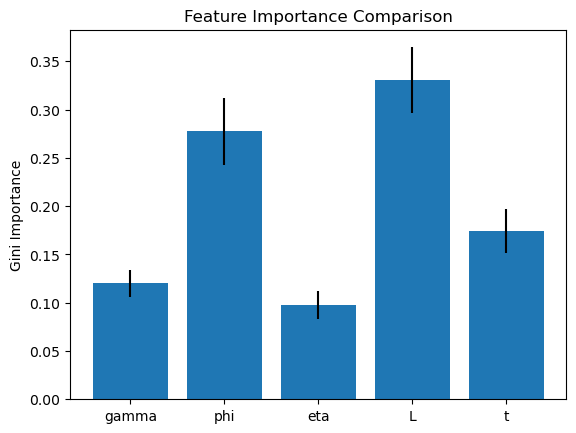

In [21]:
features_importances = biscuit_classifier.feature_importances_
features_importances_std = np.std([tree.feature_importances_ for tree in biscuit_classifier.estimators_], axis=0)

fig, ax = plt.subplots()
ax.bar(dunking_data.columns[:-1], features_importances, yerr=features_importances_std)
ax.set_ylabel('Gini Importance')
ax.set_xticks(ax.get_xticks())
ax.set_xticks(range(len(dunking_data.columns[:-1])))
ax.set_title('Feature Importance Comparison')
plt.show()

The most important parameters appear to be L (the distance up the biscuit the tea was visible) and phi (the contact angle between the biscuit and the tea surface). As the angle is controlled - is it L that is the best feature for identifying the biscuit?

# Classification using support vector machines

In [22]:
from sklearn.svm import SVC

svc = SVC(random_state=42, gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto', random_state=42)

In [26]:
y_pred = svc.predict(X_test)
testing_accuracy = svc.score(X_test, y_test) * 100
print(f'Accuracy on testing data: {testing_accuracy:.1f} %')

Accuracy on testing data: 86.1 %


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Digestive       0.94      0.89      0.91       250
      Hobnob       0.83      0.78      0.81       250
    Rich Tea       0.82      0.92      0.86       250

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750



The accuracy on the testing data appears to be higher when using  support vector machines compared to random forest.

- Precision = what percent of the predictions were correct
- recall = what percentage of positive cases were caught
- f1-score : a weighted harmonic mean of the precision and the recall, a value of 1 is the best, and 0 is the worst.
- support : the number of actual occurrences in the data.
- Note that the  𝐹1- score is valuable for comparing different models as it weighs precision and recall.

We can quantify the 'importance' of each given feature to the random forest/decision tree model.
- For this we will comput each tree's impurity decrease or Gini importance.
- This means we can plot the mean and standard deviation over all the trees.
The Gini importance tells us the impact of each feature (which we can think of as nodes) on the ratio of true to false positives in the resulting model.
- Gini featues are the specific features! Not like PCA featues.

# Support vector machine kernel comparison

In [24]:
from sklearn.metrics import f1_score

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    svc = SVC(random_state=42, gamma='auto', kernel=kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print(kernel)
    print(classification_report(y_test, y_pred))

linear
              precision    recall  f1-score   support

   Digestive       0.89      0.78      0.83       250
      Hobnob       0.72      0.66      0.69       250
    Rich Tea       0.73      0.88      0.80       250

    accuracy                           0.78       750
   macro avg       0.78      0.78      0.78       750
weighted avg       0.78      0.78      0.78       750

poly
              precision    recall  f1-score   support

   Digestive       0.84      0.66      0.74       250
      Hobnob       0.53      0.68      0.60       250
    Rich Tea       0.70      0.65      0.68       250

    accuracy                           0.66       750
   macro avg       0.69      0.66      0.67       750
weighted avg       0.69      0.66      0.67       750

rbf
              precision    recall  f1-score   support

   Digestive       0.94      0.89      0.91       250
      Hobnob       0.83      0.78      0.81       250
    Rich Tea       0.82      0.92      0.86       250

    

rbf (radial basis function) kernel appears to be the best model to fit the data (f1 score 0.86). Sigmoid is the worst - 0.49

# Running PCA on the data (principal component analysis)

In [26]:
from sklearn.decomposition import PCA

X = dunking_data[['gamma', 'phi', 'eta', 'L', 't']]
y = dunking_data['biscuit']

# scale the data again
scaled_X = StandardScaler().fit_transform(X)
scaled_X


array([[ 0.06596114, -1.16247713, -0.1763231 ,  1.55578257, -0.08375485],
       [ 0.77413155,  0.35248485,  1.10014727, -0.10948028, -1.37661828],
       [ 1.42325581,  0.356527  , -1.66054277,  0.94409822,  0.85132923],
       ...,
       [-1.37764073,  0.01241775, -0.27264257,  0.42085499,  1.13891337],
       [-0.18625557, -2.43547144,  0.29222623,  2.43276913,  0.50332741],
       [ 0.95267679,  0.4117734 , -0.02025172, -0.74059162, -0.79724642]])

In [27]:
pca = PCA(n_components = 5)
principal_components = pca.fit_transform(scaled_X)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
df_pca['biscuit'] = y

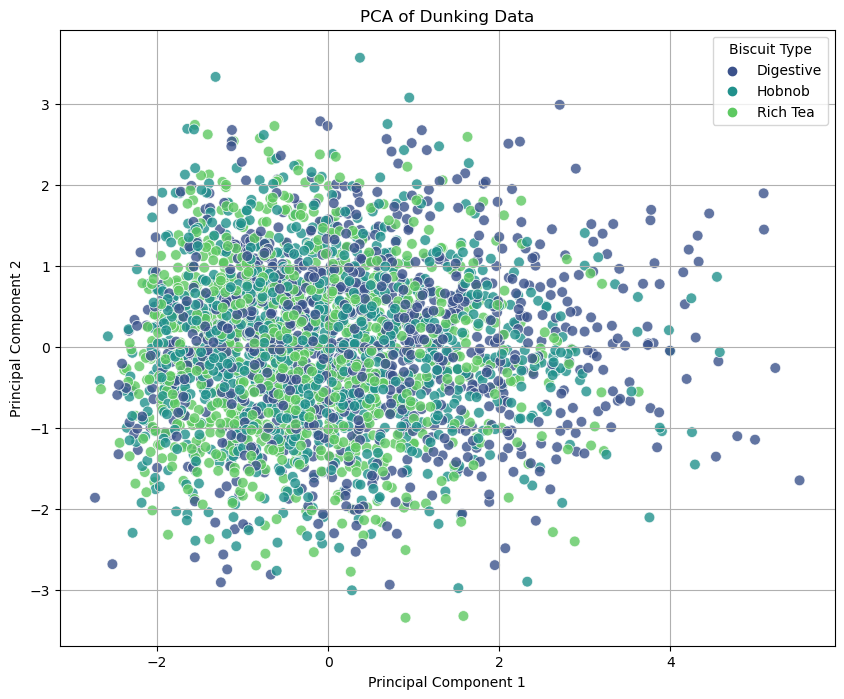

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualising the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()


In [29]:
# Visualizing the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC3', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()

In [30]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC4', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 4')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()

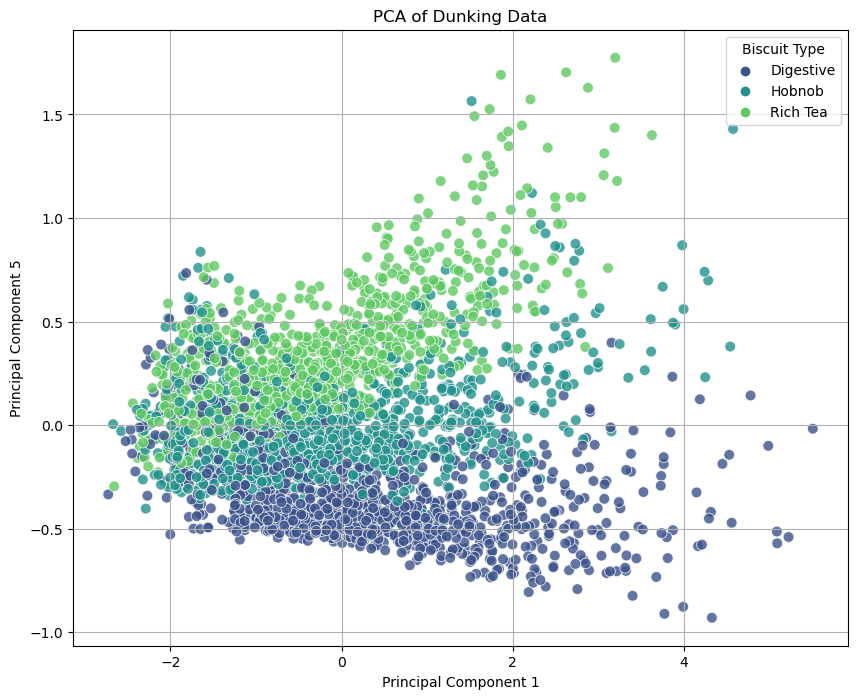

In [31]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC5', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 5')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()

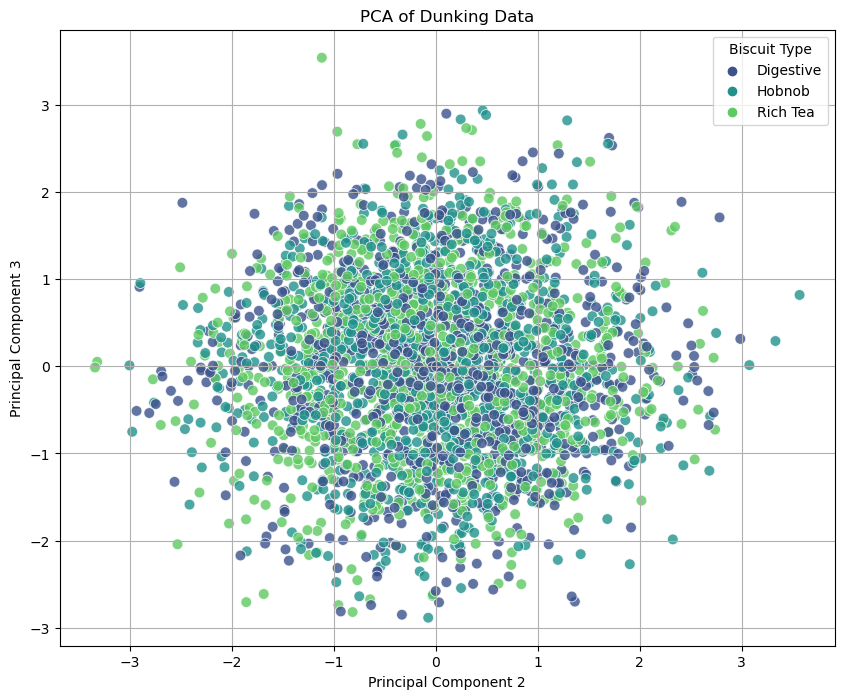

In [32]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC2', y='PC3', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()

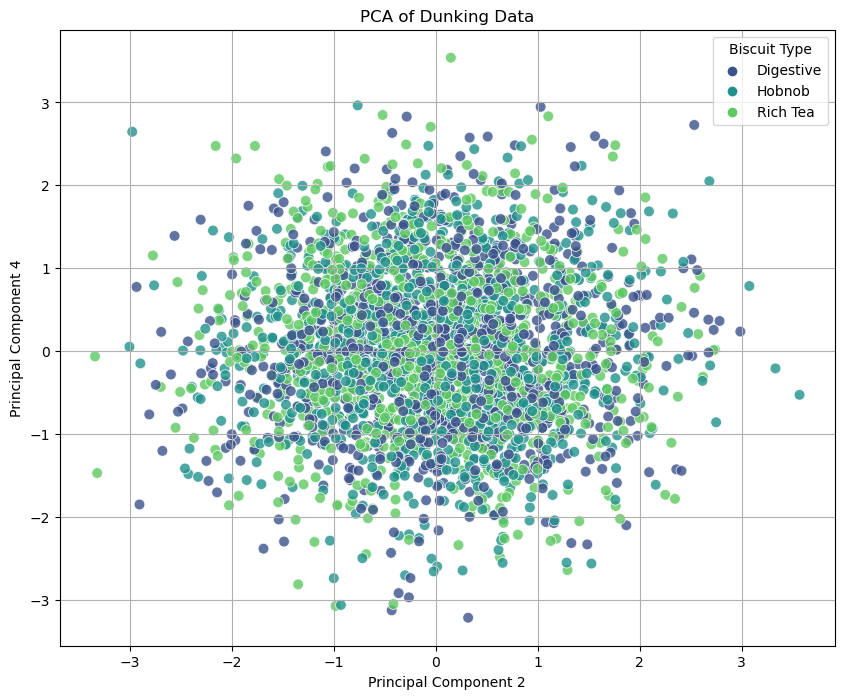

In [33]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC2', y='PC4', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 4')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()

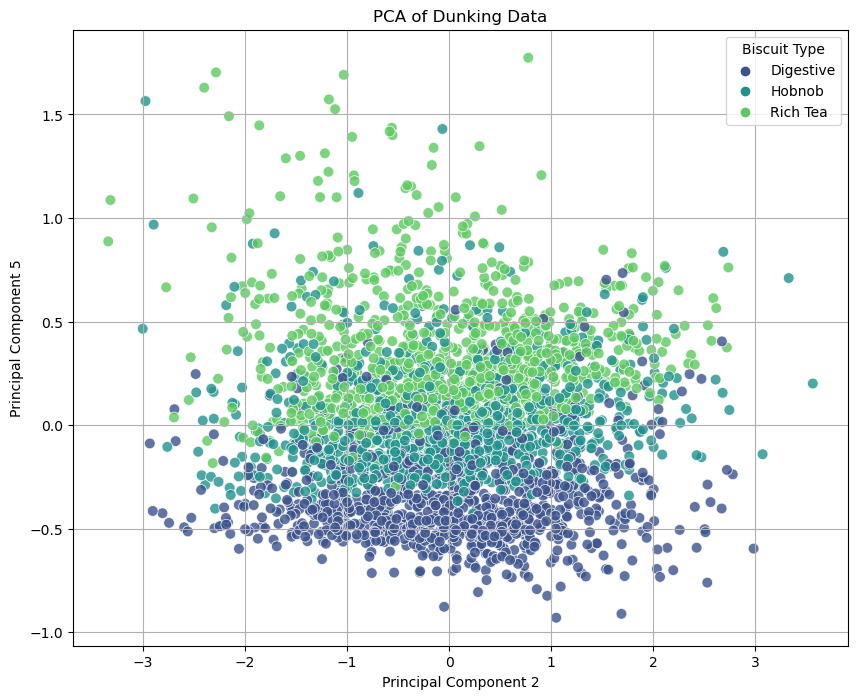

In [34]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC2', y='PC5', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 5')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()

In [35]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC3', y='PC4', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()

In [36]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC3', y='PC5', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 5')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()

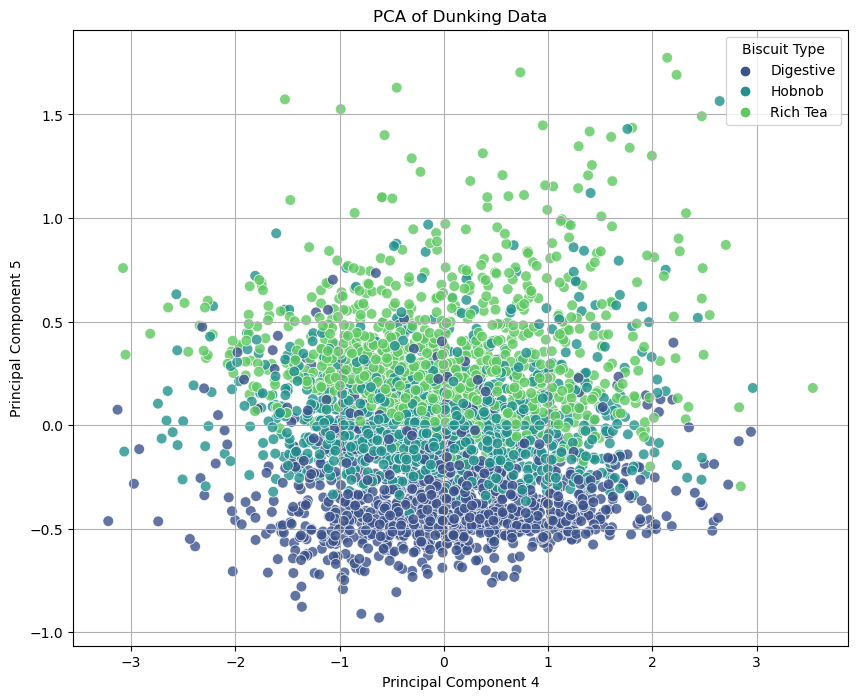

In [37]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC4', y='PC5', hue='biscuit', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('PCA of Dunking Data')
plt.xlabel('Principal Component 4')
plt.ylabel('Principal Component 5')
plt.legend(title='Biscuit Type')
plt.grid(True)
plt.show()

In [38]:
pca.explained_variance_ratio_

array([0.36987929, 0.2063917 , 0.20310831, 0.19161252, 0.02900817])

Thge first principal component accounts for around 37% of the variance in the data set, and the second 20%.

In [40]:
loading_matrix = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                              columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], 
                              index = X.columns)
ind = np.arange(len(loading_matrix.index))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ind, loading_matrix['PC1'], width, 
       label='Component 1 ({:.1f} %)'.format(pca.explained_variance_ratio_[0] * 100))
ax.bar(ind + width, loading_matrix['PC2'], width, 
       label='Component 2 ({:.1f} %)'.format(pca.explained_variance_ratio_[1] * 100))
ax.set_xlabel('Features')
ax.set_ylabel('Loading')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(loading_matrix.index)
ax.tick_params(axis='x', rotation=90)
ax.legend()
plt.show()

# PCA results

These show that L and phi have the most significant impact on principal component 1, and eta has the largest impact on principal component 2.

In [45]:
# Classifying the microscopy data using the trained model

untagged = pd.read_csv('microscopy-data.csv')

# removing pore size
untagged = untagged.drop(['r'], axis=1)
scaled_X = StandardScaler().fit_transform(untagged)
y_pred = biscuit_classifier.predict(scaled_X)
y_pred

array(['Digestive', 'Rich Tea', 'Hobnob', 'Rich Tea', 'Rich Tea',
       'Hobnob', 'Hobnob', 'Rich Tea', 'Hobnob', 'Digestive', 'Hobnob',
       'Hobnob', 'Digestive', 'Rich Tea', 'Rich Tea', 'Hobnob',
       'Rich Tea', 'Rich Tea', 'Rich Tea', 'Digestive', 'Rich Tea',
       'Hobnob', 'Digestive', 'Hobnob', 'Rich Tea', 'Hobnob', 'Hobnob',
       'Rich Tea', 'Hobnob', 'Digestive', 'Rich Tea', 'Rich Tea',
       'Hobnob', 'Hobnob', 'Digestive', 'Rich Tea', 'Rich Tea',
       'Rich Tea', 'Digestive', 'Hobnob', 'Hobnob', 'Hobnob', 'Rich Tea',
       'Hobnob', 'Rich Tea', 'Hobnob', 'Rich Tea', 'Hobnob', 'Digestive',
       'Rich Tea', 'Rich Tea', 'Digestive', 'Rich Tea', 'Digestive',
       'Hobnob', 'Rich Tea', 'Rich Tea', 'Hobnob', 'Digestive',
       'Rich Tea', 'Rich Tea', 'Rich Tea', 'Rich Tea', 'Digestive',
       'Digestive', 'Hobnob', 'Digestive', 'Rich Tea', 'Hobnob', 'Hobnob',
       'Digestive', 'Hobnob', 'Rich Tea', 'Digestive', 'Hobnob',
       'Digestive', 'Hobnob', 'Rich Tea